In [1]:
import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from scipy.stats import gaussian_kde as GKDE

from scipy.stats import multivariate_normal
from scipy.stats import norm

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import src.weightedEDFs as wEDFs
import src.distributionsDCI as distDCI
import src.utils as utils

import random

import matplotlib.patches as patches

import seaborn as sns
import matplotlib.colors as colors

import matplotlib as mpl

In [2]:
plot_directory = './plots'

if not os.path.exists(plot_directory):
    os.makedirs(plot_directory)

mpl.rcParams['lines.linewidth'] = 4
plt.rc('font', size=14)
plt.rc('axes', titlesize=16)
plt.rc('axes', labelsize=16)
mpl.rcParams['lines.markersize'] = 5
mpl.rcParams['figure.figsize'] = (5.5, 4)
mpl.rcParams['lines.linewidth'] = 2.5

CB_color_cycle = ('#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00')
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=CB_color_cycle)
plt.rcParams['image.cmap'] = 'viridis'

In [3]:
rerun_densities = False
rerun_distributions = False

## Problem setup

In [4]:
random.seed(33)
np.random.seed(55)

In [5]:
l = 2.
kappa = 1.

In [6]:
N = 100  # Specify the truncation
ts = [1e-4, 1e-2, 1e-1, 0.4, 0.8]
x = np.linspace(0, l, 2*N)

In [7]:
def u_k(k, x, t, l, kappa):
    
    return (2 * l**2 * (-1)**(k+1) / (np.pi * k)
            * np.sin(k * np.pi * x / l)
            * np.exp(-kappa * (k * np.pi)**2 * t) / l**2)

def u(N, x, t, l, kappa):
    
    u_N = 0 * x
    for k in range(1, N):
        u_N += u_k(k, x, t, l, kappa)

    return u_N

In [8]:
t = .01
sensor_loc = 1.2

## Convergence analysis

In [10]:
low_x = 2.01
upp_x = 2.02
low_y = 0.95
upp_y = 1.0

upp_B = u(N, sensor_loc, t, low_x, low_y)
low_B = u(N, sensor_loc, t, upp_x, upp_y)

delta_l = 0.1
delta_kappa = 0.5

print(f'Upper of B = {upp_B}')
print(f'Lower of B = {low_B}')

Upper of B = 0.5935544013268559
Lower of B = 0.5899603114552461


In [11]:
X = np.linspace(l - delta_l / 2, delta_l + l - delta_l / 2, 100)
Y = np.linspace(kappa - delta_kappa / 2, delta_kappa + kappa - delta_kappa / 2, 100)

XX, YY = np.meshgrid(X, Y)
ZZ = np.zeros(np.shape(XX))

for count, x in enumerate(X):
    ZZ[count,:] = u(N, sensor_loc, t, XX[count,:], YY[count,:])

In [12]:
obs_dist = norm(0.595, 3e-3)

n_obs_samples = 50000
obs_samples = obs_dist.rvs(n_obs_samples)

d_min = np.min(ZZ)
d_max = np.max(ZZ)

print(d_min)
print(d_max)

obs_KDE = GKDE(obs_samples)

0.5766339652753646
0.6136972780535532


In [13]:
n_init_samples = 20000
n_density_trials = 100

In [14]:
if rerun_densities:

    true_up_prob_set = []
    for trial in range(n_density_trials):

        print(f'working on trial {trial}')

        init_samples = np.random.uniform(0, 1, (n_init_samples, 2))
        init_samples[:,0] = init_samples[:,0] * delta_l + l - delta_l / 2
        init_samples[:,1] = init_samples[:,1] * delta_kappa + kappa - delta_kappa / 2

        pred_samples = np.zeros((n_init_samples, 1))
        pred_samples[:, 0] = u(N, sensor_loc, t, init_samples[:,0], init_samples[:,1])
        pred_KDE = GKDE(pred_samples[:,0])

        r = obs_KDE(pred_samples.T) / pred_KDE(pred_samples.T)
        rn_w = r / n_init_samples

        true_up_prob_set.append(0)
        for i, isamp in enumerate(init_samples):
            if isamp[0] >= low_x and isamp[0] <= upp_x and isamp[1] >= low_y and isamp[1] <= upp_y:
                true_up_prob_set[int(trial)] += rn_w[i]
                
    np.save('./data/convergence_dens_prob_A.npy', np.array(true_up_prob_set))

else:

    init_samples = np.random.uniform(0, 1, (n_init_samples,2))
    init_samples[:,0] = init_samples[:,0] * delta_l + l - delta_l / 2
    init_samples[:,1] = init_samples[:,1] * delta_kappa + kappa - delta_kappa / 2

    pred_samples = np.zeros((n_init_samples, 1))
    pred_samples[:, 0] = u(N, sensor_loc, t, init_samples[:,0], init_samples[:,1])
    pred_KDE = GKDE(pred_samples[:,0])

    r = obs_KDE(pred_samples[:,0].T) / pred_KDE(pred_samples[:,0].T)
    rn_w = r / n_init_samples

    true_up_prob_set = np.load('./data/convergence_dens_prob_A.npy')

obs_prob_set = obs_dist.cdf(upp_B) - obs_dist.cdf(low_B)

print(np.std(true_up_prob_set))
print(np.mean(true_up_prob_set))

true_up_prob_set = np.mean(true_up_prob_set)

0.0013338758754257768
0.01961062634271982


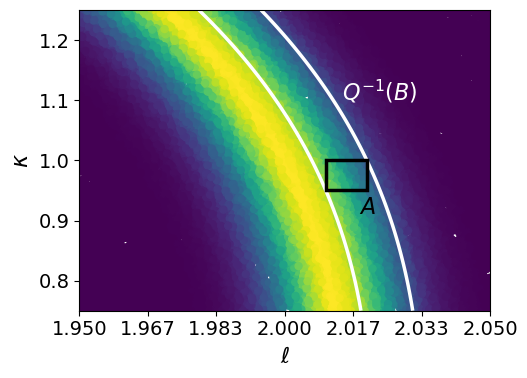

In [15]:
ax = plt.gca()

plt.scatter(init_samples[:,0], init_samples[:,1], c=r/n_init_samples)

plt.contour(XX, YY, ZZ, levels=[low_B, upp_B], colors=['w', 'w']);

set_A = patches.Rectangle((low_x, low_y), upp_x-low_x, upp_y-low_y, color='k',
                          fill=None, zorder=10, linewidth=2.5)
ax.add_patch(set_A)

plt.text(upp_x-0.002, low_y-0.04, r'$A$', fontsize=16)
plt.text(upp_x-0.006, upp_y+0.1, r'$Q^{-1}(B)$', fontsize=16, color='w')

plt.xlabel(r'$\ell$')
plt.ylabel(r'$\kappa$')
plt.xticks(ticks=np.linspace(np.min(XX), np.max(XX), 7),
           labels=["{:.3f}".format(x) for x in np.linspace(np.min(XX), np.max(XX), 7)])

plt.tight_layout()

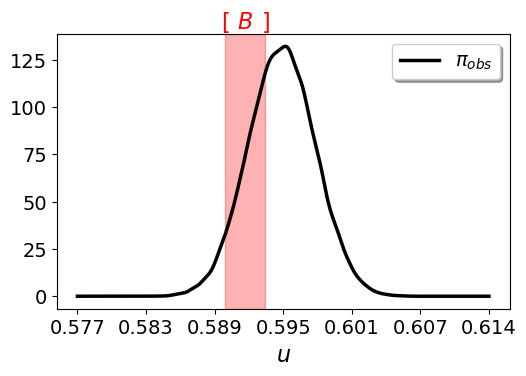

In [16]:
xx = np.linspace(np.min(pred_samples[:,0]), np.max(pred_samples[:,0]), 1000)
plt.plot(xx, obs_KDE(xx), label=r'$\pi_{obs}$', color='k')
plt.yticks(fontsize=14)
plt.text((upp_B-low_B)/2 + low_B, 145, r'$B$', color='r', fontsize=16,
         horizontalalignment='center', verticalalignment='center')
plt.text(low_B, 145, r'$[$', color='r', fontsize=16, horizontalalignment='center', verticalalignment='center')
plt.text(upp_B, 145, r'$]$', color='r', fontsize=16, horizontalalignment='center', verticalalignment='center')
plt.axvspan(low_B, upp_B, alpha=0.3, color='r')

plt.legend(loc='upper right', shadow=True)
plt.xlabel(r'$u$')
plt.xticks(ticks=np.linspace(np.min(xx), np.max(xx), 7),
           labels=["{:.3f}".format(x) for x in np.linspace(np.min(xx), np.max(xx), 7)], color='k')

plt.tight_layout()

In [17]:
bin_numbers = [20, 40, 60, 80, 100, 120, 140,160]
sampling_samples_numbers = [1000, 2000, 3000, 4000, 5000]

In [18]:
n_trials = 100

In [19]:
low_l = l - delta_l/2
upp_l = l + delta_l/2
low_k = kappa - delta_kappa/2
upp_k = kappa + delta_kappa/2

In [20]:
def init_cdf(x,y):
    return np.min([(x - low_l),0]) * np.min([(y - low_k),0])

In [21]:
if rerun_distributions == True:

    c_A = []
    c_B = []

    for trial in range(n_trials):
        
        print(f'working on trial {trial}')

        comp_prob_A = []
        comp_prob_B = []

        sampling_samples_full = np.random.normal(0, 1, (sampling_samples_numbers[-1], 2))
        sampling_samples_full[:,1] = np.random.beta(2, 5, (sampling_samples_numbers[-1])) * 2 + 0.5
        sampling_samples_full[:,0] = sampling_samples_full[:,0] * delta_l + l

        which_outside = ((sampling_samples_full[:,0] < 1.94) | (sampling_samples_full[:,0] > 2.06)
                         | (sampling_samples_full[:,1] < 0.7) | (sampling_samples_full[:,1] > 1.3))
        n_outside = np.sum(which_outside)

        while n_outside > 0:
            sampling_samples_full[which_outside,:] = np.random.normal(0, 1, (n_outside, 2))
            sampling_samples_full[which_outside,1] = np.random.beta(2, 5, (n_outside)) * 2 + 0.5
            sampling_samples_full[which_outside,0] = sampling_samples_full[which_outside,0] * delta_l + l

            which_outside = ((sampling_samples_full[:,0] < 1.94) | (sampling_samples_full[:,0] > 2.06)
                             | (sampling_samples_full[:,1] < 0.7) | (sampling_samples_full[:,1] > 1.3))
            n_outside = np.sum(which_outside)
    
        pred_samples_full = np.zeros((sampling_samples_numbers[-1], 1))
        pred_samples_full[:, 0] = u(N, sensor_loc, t,
                                    sampling_samples_full[:,0], sampling_samples_full[:,1])

        for i, n_sampling_samples in enumerate(sampling_samples_numbers):

            print(f'nsamples = {n_sampling_samples}')

            comp_prob_A.append([])
            comp_prob_B.append([])

            sampling_samples = sampling_samples_full[:n_sampling_samples,:]

            pred_samples = pred_samples_full[:n_sampling_samples,:]

            for b, n_bins in enumerate(bin_numbers):

                w, bins, centers, w_center = distDCI.computePartitionedWeights_regulargrid_nonIID(sampling_samples,
                                                                        pred_samples,
                                                                        init_samples,
                                                                        sample_set_2=np.reshape(obs_samples, (len(obs_samples),1)),
                                                                        n_bins=n_bins)

                weight_set = 0
                for count, psamp in enumerate(pred_samples): 
                    if psamp >= low_B and psamp <= upp_B:
                        weight_set += w[count]

                up_prob_set = 0
                for count, isamp in enumerate(sampling_samples):
                    if isamp[0] >= low_x and isamp[0] <= upp_x and isamp[1] >= low_y and isamp[1] <= upp_y:
                        up_prob_set += w[count]

                comp_prob_B[i].append(weight_set)
                comp_prob_A[i].append(up_prob_set)

        c_A.append(comp_prob_A)
        c_B.append(comp_prob_B)

    dist_prob_A = np.array(c_A)
    dist_prob_B = np.array(c_B)

    np.save('./data/convergence_precomp_prob_A.npy', dist_prob_A.reshape(n_trials, -1))
    np.save('./data/convergence_precomp_prob_B.npy', dist_prob_B.reshape(n_trials, -1))
    
else:

    dist_prob_A = np.load('./data/convergence_precomp_prob_A.npy').reshape(n_trials,
                                                                        len(sampling_samples_numbers),
                                                                        len(bin_numbers))
    dist_prob_B = np.load('./data/convergence_precomp_prob_B.npy').reshape(n_trials,
                                                                        len(sampling_samples_numbers),
                                                                        len(bin_numbers))

In [22]:
ccc_A = np.mean(dist_prob_A, axis=0)
ccc_B = np.mean(dist_prob_B, axis=0)

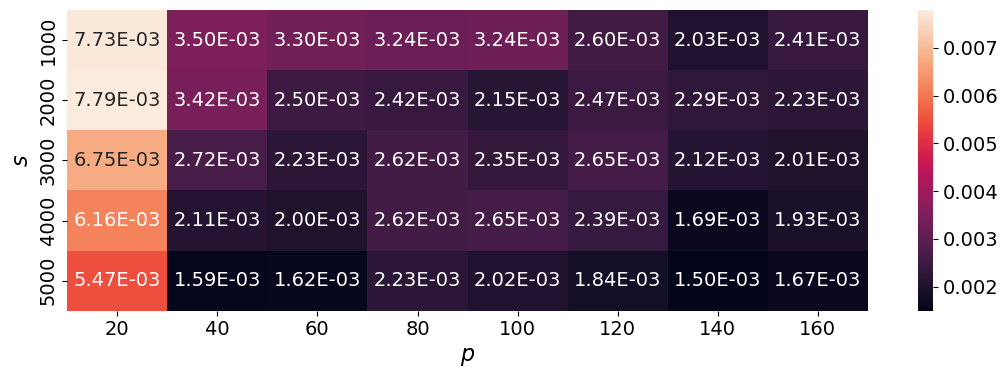

In [23]:
plt.figure(figsize=(11,4))

s = sns.heatmap(np.abs(np.array(ccc_B)-obs_prob_set), annot=True, fmt='0.2E',
            yticklabels=sampling_samples_numbers, xticklabels=np.array(bin_numbers));

s.set_xlabel(r'$p$')
s.set_ylabel(r'$s$')

plt.tight_layout()
plt.savefig(f'{plot_directory}/sampling_heatmap_meanB.png', bbox_inches='tight')

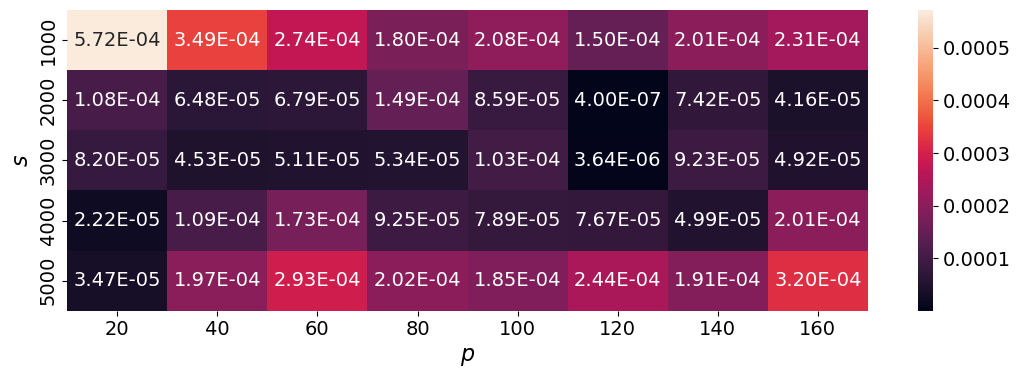

In [24]:
plt.figure(figsize=(11,4))

s = sns.heatmap(np.abs(np.array(ccc_A)-true_up_prob_set), annot=True, fmt='0.2E',
                yticklabels=sampling_samples_numbers, xticklabels=np.array(bin_numbers));

s.set_xlabel(r'$p$')
s.set_ylabel(r'$s$')

plt.tight_layout()
plt.savefig(f'{plot_directory}/sampling_heatmap_meanA.png', bbox_inches='tight')

In [25]:
frow_string = f'        '
for i in bin_numbers:
    frow_string += f' {i:6d}  '

print(frow_string)
for ii, b in enumerate(ccc_A):
    row_string = f'{sampling_samples_numbers[ii]:5d}   '
    for i in b:
        if i != -999:
            row_string += f'{i:.5f}  '
        else:
            row_string += f'         '
    print(row_string)

print()
print(f'actual probability of A = {true_up_prob_set:.5f}')

             20       40       60       80      100      120      140      160  
 1000   0.01904  0.01926  0.01988  0.01943  0.01940  0.01976  0.01981  0.01984  
 2000   0.01950  0.01968  0.01968  0.01946  0.01952  0.01961  0.01954  0.01957  
 3000   0.01953  0.01966  0.01966  0.01956  0.01951  0.01961  0.01952  0.01956  
 4000   0.01959  0.01972  0.01978  0.01970  0.01969  0.01969  0.01966  0.01981  
 5000   0.01965  0.01981  0.01990  0.01981  0.01980  0.01985  0.01980  0.01993  

actual probability of A = 0.01961


In [26]:
cccc_A = np.std(dist_prob_A, axis=0)
cccc_B = np.std(dist_prob_B, axis=0)

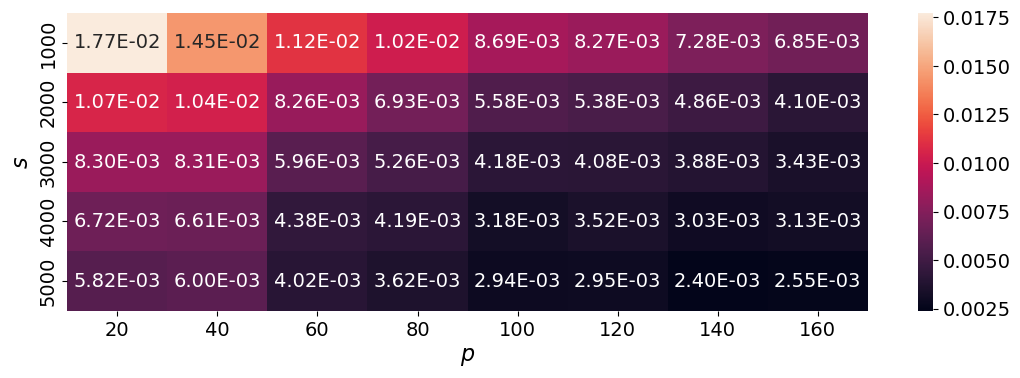

In [27]:
plt.figure(figsize=(11,4))

s = sns.heatmap(np.abs(np.array(cccc_B)), annot=True, fmt='0.2E',
                yticklabels=sampling_samples_numbers, xticklabels=np.array(bin_numbers));

s.set_xlabel(r'$p$')
s.set_ylabel(r'$s$')

plt.tight_layout()
plt.savefig(f'{plot_directory}/sampling_heatmap_stdB.png', bbox_inches='tight')

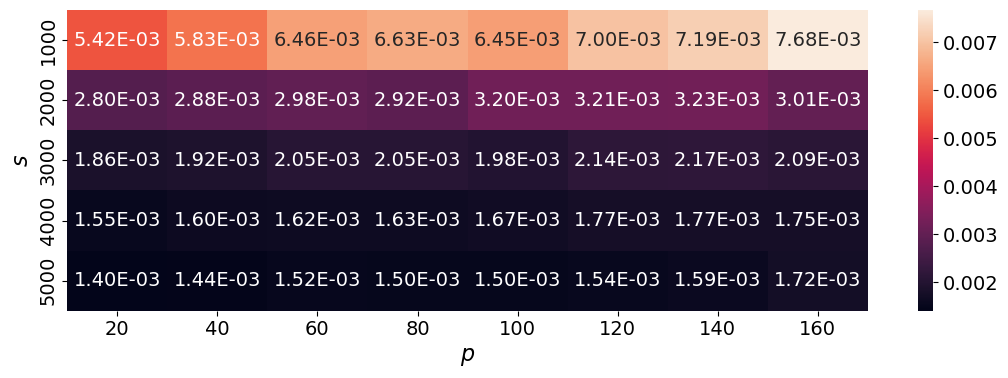

In [28]:
plt.figure(figsize=(11,4))

s = sns.heatmap(np.abs(np.array(cccc_A)), annot=True, fmt='0.2E',
                yticklabels=sampling_samples_numbers, xticklabels=np.array(bin_numbers));
s.set_xlabel(r'$p$')
s.set_ylabel(r'$s$')

plt.tight_layout()
plt.savefig(f'{plot_directory}/sampling_heatmap_stdA.png', bbox_inches='tight')